In [1]:
import os
import json
import time
import copy
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from skimage import io

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import imgaug as ia
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
# PATH_ANNO = r'../input/pascal_voc/PASCAL_VOC/pascal_train2007.json'
# PATH_IMG = r'../input/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages'
PATH_ANNO = r'/home/spacor/fastai/courses/dl2/data/PASCAL_VOC/pascal_train2007.json'
PATH_IMG = r'/home/spacor/fastai/courses/dl2/data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages'

In [3]:
def get_img_annotations(path_annotations):
#     PATH_ANNO = r'../input/pascal_voc/PASCAL_VOC/pascal_train2007.json'
    anno_raw=json.load(open(path_annotations))
    imgId_anno_map = defaultdict(list)
    for i in anno_raw['annotations']:
        imgId_anno_map[i['image_id']].append(i)
    
    img_anno = []
    for i in anno_raw['images']:
        tmp_anno = imgId_anno_map[i['id']]
        tmp_rcd = i
        tmp_rcd['annotation'] = tmp_anno
        img_anno.append(tmp_rcd)
    return img_anno

def transform_anno(raw_annotations):
    transformed_annotations = []
    for raw_annotation in raw_annotations:
        tmp_anno = {'filename': raw_annotation['file_name'],
                   'bboxes': [{'bbox': i['bbox'], 'category_id': i['category_id']} for i in raw_annotation['annotation']]
                   }
        transformed_annotations.append(tmp_anno)
    return transformed_annotations

def get_obj_category_mappings(path_annotations):
    anno_raw=json.load(open(path_annotations))
    catId_name_map = dict()
    for i in anno_raw['categories']:
        catId_name_map[i['id']] = i['name']
    return catId_name_map

In [4]:
img_anno = transform_anno(get_img_annotations(PATH_ANNO))
img_cate_map = get_obj_category_mappings(PATH_ANNO)

max_bouding_box = int(np.array([len(i['bboxes']) for i in img_anno]).max()) #max number of bounding box in sample
num_classes = len(img_cate_map) + 1 #one for background

img_anno[1]

{'filename': '000017.jpg',
 'bboxes': [{'bbox': [184, 61, 95, 138], 'category_id': 15},
  {'bbox': [89, 77, 314, 259], 'category_id': 13}]}

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b):
    """
    b: bounding box (list) top left point coordinate, width, height (x, y, w, h)
    """
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_img_bbs(img, bboxes, texts):
    """
    Show img alongside with all bboxes
    img: np array of image
    bboxes: list of bbox in top left point coordinate, width, height (x, y, w, h)
    texts: list of annotation (categories) of bbox
    """
    ax = show_img(img)
    for tmp_bbox, tmp_text in zip(bboxes, texts):
        bb = tmp_bbox
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], tmp_text)

In [6]:
#test show image and bounding box
tmp = img_anno[1]
tmp_img = io.imread(os.path.join(PATH_IMG, tmp['filename']))
tmp_bb = [i['bbox'] for i in tmp['bboxes']]
tmp_cat = [img_cate_map[i['category_id']] for i in tmp['bboxes']]

# show_img_bbs(tmp_img, tmp_bb, tmp_cat)

In [7]:
#Test augmentation - img only
seq = iaa.Sequential([
    iaa.Scale({"height": 224, "width": 224}),
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            rotate=(-25, 25),
        )
    ], random_order=True) # apply augmenters in random order
], random_order=False)

tmp_tfm_img = seq.augment_images([tmp_img.copy(),tmp_img.copy()])
# show_img_bbs(tmp_tfm_img[0], [], [])

In [8]:
#Test augmentation - img + bbox
seq = iaa.Sequential([
    iaa.Scale({"height": 224, "width": 224}),
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            rotate=(-25, 25),
        )
    ], random_order=True) # apply augmenters in random order
], random_order=False)
convert_bb_fmt = lambda bb: [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]] #convert topleft xy, wh to min x, min y, max x,  max y

#read raw data
tmp = img_anno[1]
tmp_img = io.imread(os.path.join(PATH_IMG, tmp['filename']))
tmp_bb = [i['bbox'] for i in tmp['bboxes']]
tmp_bb_obj = ia.BoundingBoxesOnImage([ia.BoundingBox(*convert_bb_fmt(i)) for i in tmp_bb], shape=tmp_img.shape) #convert to Boundingboxes object
tmp_cat = [img_cate_map[i['category_id']] for i in tmp['bboxes']]

#augmentation
seq_det = seq.to_deterministic()
tmp_aug_img = seq_det.augment_images([tmp_img.copy()])[0]
tmp_aug_bbs_raw = seq_det.augment_bounding_boxes([tmp_bb_obj])[0].remove_out_of_image().cut_out_of_image()

#convert back to generally accepted format
reverse_bb_fmt = lambda bb_obj: [bb_obj.x1, bb_obj.y1, bb_obj.width, bb_obj.height]
tmp_aug_bbs = [reverse_bb_fmt(i) for i in tmp_aug_bbs_raw.bounding_boxes]

#display
# show_img_bbs(tmp_aug_img, tmp_aug_bbs, tmp_cat)

In [9]:
#filter largest bbox
sort_by_area = lambda bboxes: bboxes['bbox'][2] * bboxes['bbox'][3]
img_anno_largest_bbox_only = deepcopy(img_anno)
for i in img_anno_largest_bbox_only:
    i['bboxes'].sort(reverse = True, key = sort_by_area)
    i['bboxes'] = [i['bboxes'][0]]

img_anno_largest_bbox_only[:5]

[{'filename': '000012.jpg',
  'bboxes': [{'bbox': [155, 96, 196, 174], 'category_id': 7}]},
 {'filename': '000017.jpg',
  'bboxes': [{'bbox': [89, 77, 314, 259], 'category_id': 13}]},
 {'filename': '000023.jpg',
  'bboxes': [{'bbox': [2, 1, 241, 461], 'category_id': 15}]},
 {'filename': '000026.jpg',
  'bboxes': [{'bbox': [89, 124, 248, 88], 'category_id': 7}]},
 {'filename': '000032.jpg',
  'bboxes': [{'bbox': [103, 77, 272, 106], 'category_id': 1}]}]

In [10]:
class PascalDataset(Dataset):
    def __init__(self, img_meta, transform = None):
        self.img_meta = img_meta
        self.transform = transform
        
    def __len__(self):
        return len(self.img_meta)
    
    def __getitem__(self, idx):
        
        img = io.imread(os.path.join(PATH_IMG, self.img_meta[idx]['filename']))
        bboxes = [i['bbox'] for i in self.img_meta[idx]['bboxes']]
        categories = [i['category_id'] for i in self.img_meta[idx]['bboxes']]
        
        if bool(self.transform) is True:
            img_boxes = (img, bboxes)
            img, bboxes = self.transform(img_boxes)
        
#         categories = categories[0] #largest boxes only
        categories = torch.tensor(categories)
        
        bboxes = bboxes[0] #largest boxes only
        
        output = (img, (bboxes, categories))
        return output

class ImgBBoxTfm:
    def __init__(self, output_size = 224, aug_pipline = None):
        self.output_size = output_size
        self.seq = aug_pipline
    
    def __call__(self, img_boxes):
        """
        img_boxes: tuple of image, bboxes. bboxes are array of bbox
        """
        img, bboxes = img_boxes
        convert_bb_fmt = lambda bb: [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]] #convert topleft xy, wh to min x, min y, max x,  max y
        reverse_bb_fmt = lambda bb_obj: [bb_obj.x1_int, bb_obj.y1_int, int(bb_obj.width), int(bb_obj.height)]
        
        raw_image = img
        raw_bbs = ia.BoundingBoxesOnImage([
            ia.BoundingBox(*convert_bb_fmt(bb)) for bb in bboxes
        ], shape=raw_image.shape)
        
        seq_det = self.seq.to_deterministic()
        image_aug = seq_det.augment_images([raw_image])[0]
        bbs_aug = seq_det.augment_bounding_boxes([raw_bbs])[0].remove_out_of_image().cut_out_of_image()
        bbs_aug = [reverse_bb_fmt(bb) for bb in bbs_aug.bounding_boxes]
        img_boxes = (image_aug, bbs_aug)
        return img_boxes

class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, img_boxes):
        img, bboxes = img_boxes
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img = np.clip(img, a_min=0, a_max=None)
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).float().div(255)
        bboxes = torch.from_numpy(np.array(bboxes)).float()
        img_boxes = (img, bboxes)
        return img_boxes

class NormalizeImg:
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        
    def __call__(self, img_boxes):
        img, bboxes = img_boxes
        img = self.normalize(img)
        img_boxes = (img, bboxes)
        return img_boxes

In [11]:
def get_aug_pipline(img_size, mode = 'train'):
    if mode == 'train':
        seq = iaa.Sequential([
            iaa.Scale({"height": img_size, "width": img_size}),
            iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Sometimes(0.5,
                    iaa.GaussianBlur(sigma=(0, 0.5))
                ),
                iaa.ContrastNormalization((0.75, 1.5)),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                iaa.Affine(
                    rotate=(-25, 25),
                )
            ], random_order=True) # apply augmenters in random order
        ], random_order=False)
    else: #ie.val
        seq = iaa.Sequential([
            iaa.Scale({"height": img_size, "width": img_size}),
        ], random_order=False)
    return seq

In [12]:
def inverse_transform(img_torch):
    """denormalize and inverse transform"""
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    tmp = deepcopy(img_torch)
    inv_normalize(tmp)
    tmp = np.clip((tmp.numpy().transpose((1,2,0)) * 255), a_min=0, a_max=255).astype(np.int)
    return tmp

In [13]:
IMG_SIZE = 224
BATCH_SIZE = 16
VAL_SIZE =0.33

train_set, val_set = train_test_split(img_anno_largest_bbox_only, test_size=VAL_SIZE, random_state=42)

composed = {}
composed['train'] = transforms.Compose([ImgBBoxTfm(output_size=IMG_SIZE, aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'train')), 
                                     ToTensor(), 
                                     NormalizeImg()])
composed['val'] = transforms.Compose([ImgBBoxTfm(output_size=IMG_SIZE, aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'val')), 
                                     ToTensor(), 
                                     NormalizeImg()])

image_datasets = {'train': PascalDataset(train_set, transform=composed['train']),
                 'val': PascalDataset(val_set, transform=composed['val'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
              for x in ['train', 'val']}

In [14]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 1675, 'val': 826}


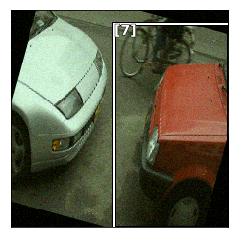

In [15]:
#test dataset and transformation pipline

tmp = image_datasets['train'][3]
tmp_img = tmp[0]
tmp_bboxes = [list(tmp[1][0].numpy())]
tmp_cat = [tmp[1][1].numpy()] #for largest box

show_img_bbs(inverse_transform(tmp_img), tmp_bboxes, tmp_cat) 

In [16]:
# Get a batch of training data
inputs, targets = next(iter(dataloaders['train']))

In [17]:
targets[0].div(IMG_SIZE)

tensor([[ 0.3170,  0.3527,  0.3929,  0.3170],
        [ 0.0804,  0.4375,  0.6518,  0.4375],
        [ 0.6652,  0.4598,  0.3348,  0.4509],
        [ 0.0714,  0.0759,  0.6964,  0.9107],
        [ 0.1652,  0.1384,  0.5402,  0.7991],
        [ 0.1027,  0.0000,  0.8795,  0.9598],
        [ 0.1786,  0.4732,  0.3214,  0.5223],
        [ 0.2366,  0.6250,  0.1473,  0.1205],
        [ 0.0000,  0.0759,  1.0000,  0.7723],
        [ 0.0000,  0.0000,  1.0000,  1.0000],
        [ 0.0134,  0.1964,  0.7366,  0.7232],
        [ 0.1607,  0.2545,  0.6250,  0.3973],
        [ 0.0000,  0.0000,  1.0000,  1.0000],
        [ 0.7277,  0.4107,  0.2723,  0.4955],
        [ 0.0179,  0.0982,  0.7768,  0.8705],
        [ 0.2411,  0.4821,  0.6696,  0.5179]])

In [18]:
targets[1]

tensor([[ 19],
        [ 14],
        [ 18],
        [ 14],
        [ 12],
        [ 12],
        [  9],
        [  7],
        [  1],
        [ 14],
        [ 14],
        [ 18],
        [ 16],
        [ 18],
        [  8],
        [ 18]])

In [19]:
targets[1].squeeze(1)

tensor([ 19,  14,  18,  14,  12,  12,   9,   7,   1,  14,  14,  18,
         16,  18,   8,  18])

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:
                bboxes, categories = targets
                categories = categories.squeeze(1) #for largest item classification only
                inputs = inputs.to(device)
#                 bboxes = bboxes.to(device)
                categories = categories.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, categories)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == categories.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
#define model
class RNetCustom(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        for param in self.backbone.parameters():
            param.require_grad = False
        self.backbone.fc = nn.Linear(512, num_class)
    def forward(self, x):
        y_pred = self.backbone(x)
        return y_pred

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = RNetCustom(num_class=num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 2.0948 Acc: 0.4185
val Loss: 1.1789 Acc: 0.6731

Epoch 1/4
----------
train Loss: 1.1846 Acc: 0.6549
val Loss: 0.8765 Acc: 0.7397

Epoch 2/4
----------
train Loss: 0.9242 Acc: 0.7230
val Loss: 0.7540 Acc: 0.7567

Epoch 3/4
----------
train Loss: 0.7403 Acc: 0.7791
val Loss: 0.7408 Acc: 0.7421

Epoch 4/4
----------
train Loss: 0.6391 Acc: 0.8048
val Loss: 0.7176 Acc: 0.7567

Training complete in 1m 59s
Best val Acc: 0.756659
